# Read .smr files into Python using NEO

<a id='section1'></a>
## ***(1) Load and Check Python packages***


In [1]:
# load Python modules
# !python -m pip install sonpy
# !python -m pip install /home/shiva/Downloads/python-neo-0.10.0 ## neo version 10 is not released yet you have to download the release from github

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import neo
import sys
import csv
import os
print("Neo version = ", neo.__version__)
print("Python version = ", sys.version)

# plot the output of matplotlib commands in the notebook
%matplotlib inline

Neo version =  0.10.0
Python version =  3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


<a id='section2'></a>
##  (2) Read .smr/.smrx file with Neo
##### [back to top](#section1)

### input filepath:

In [6]:
filepath='/home/shiva/Desktop/SquarePulse_k03_D2only_test.smr'
filepath="/home/shiva/Desktop/SquarePulse_k03_D2only.smrx"
filepath = '/home/shiva/Desktop/Beta STR_s01.smrx'

In [7]:

def read_laser_file(filepath):
    filename = os.path.basename(filepath)
    file_extension = filename.split('.') [-1]
    
    ## Depending on the file extension, the laser information is stored differently
    if file_extension == 'smrx':
        neo_obj = neo.CedIO(filepath)
        analogsignals = read_neo_file_return_analogsignals(neo_obj)
        
        # keep the signal as a 16 bit float
        laser_series = np.float16(analogsignals[1]) # the laser information is stored as the second analog signal
    else:
        neo_obj = neo.Spike2IO(filepath)
        analogsignals = read_neo_file_return_analogsignals(neo_obj)
        
        # keep the signal as a 16 bit float
        laser_series = np.float16(analogsignals[1][:,1]) # the laser information is stored as the second column in the 
                                             # the second analog signal
        
    return laser_series

def read_neo_file_return_analogsignals(neo_obj):
    
    block = neo_obj.read()[0] # read the file 
    analogsignals = block.segments[0].analogsignals
    report_info_on_file(block, analogsignals)
    
    return analogsignals

def report_info_on_file(block, analogsignals):
    
    print('number of segments = ', len(block.segments))
    print('number of analog signals = ', len(analogsignals))
    for i in range(len(analogsignals)):
        print('signal {} contains {} series'.format(i+1, analogsignals[i].shape))
        
laser_series = read_laser_file(filepath)

number of segments =  1
number of analog signals =  4
signal 1 contains (129501, 1) series
signal 2 contains (129501, 1) series
signal 3 contains (129501, 1) series
signal 4 contains (12950, 1) series


Properties of the laser series are:

In [10]:
fs = 1000 # sampling rate
laser_threshold = 4 # 
pts = int(np.prod(laser_series.shape)) # number of datapoints
secs = pts/fs # recording length in seconds
time = np.linspace(0, secs, pts)
print('{} data points\n{} sec\n'.format(
        pts, secs))

129501 data points
129.501 sec



## (3) Find laser epochs 

### (3.0) Determine the type of stim

In [5]:
def determine_stim_type(laser_series, freq_thresh = 0.5, peak_height_thresh = 1, fs = 1000 ):
    
    fs = 1000 # sampling rate
    pts = int(np.prod(laser_series.shape)) # number of datapoints
    secs = pts/fs # recording length in seconds
    laser_series = laser_series.reshape(-1,)
    peaks,_ = find_peaks(laser_series, height = peak_height_thresh)
    frequency_of_peaks = len(peaks)/ secs
    print("frequency of detected peaks = {}".format(frequency_of_peaks))
    if frequency_of_peaks > freq_thresh : 
        stim_type = "BetaPulse"
    else: 
        stim_type = "SquarePulse"
    print(" freq > {} Hz constitues a BetaPulse. \n Therefore, this signal is a {}".format(freq_thresh, stim_type))
    return stim_type

determine_stim_type(laser_series, freq_thresh = 0.5, peak_height_thresh = 1, fs = 1000 )

frequency of detected peaks = 0.21959682023804294
 freq > 0.5 Hz constitues a BetaPulse. 
 Therefore, this signal is a SquarePulse


'SquarePulse'

### (3.1) SquarePulse stimulation

In [6]:
def laser_start_and_end_SquarePulse(laser_series, laser_threshold = 4):
    peaks = (laser_series > laser_threshold).reshape(1,-1)[0]
    peaks = peaks * 1
    shifted_right = np.roll(peaks, 1)
    shifted_left = np.roll(peaks, -1)

    laser_start = np.where(peaks - shifted_right > 0)[0]
    laser_end = np.where(peaks - shifted_left > 0)[0]
    
    print("number of SquarePulse stimulations = {}".format(len(laser_start)))
    
    return laser_start, laser_end
laser_start, laser_end = laser_start_and_end_SquarePulse(laser_series, laser_threshold = 4)
# print('laser starts = \n\n', time[laser_start],
#       '\n\n laser ends = \n\n', time[laser_end])

number of SquarePulse stimulations = 22


### (3.2) BetaPulse stimulation

In [23]:
def laser_start_and_end_BetaPulse(laser_series, 
                                  peak_height_thresh = 1, 
                                  min_dist_bet_laser_coef = 1.5):
    laser_series = np.array(laser_series)
    laser_series = laser_series.reshape(-1,)
    peaks,_ = find_peaks(laser_series, height = peak_height_thresh)
    peaks = np.array(peaks)
    dist_bet_peaks = np.diff(peaks)
    
    most_freq = np.argmax(np.bincount(dist_bet_peaks))
    
    laser_end = peaks[np.where(dist_bet_peaks > min_dist_bet_laser_coef * most_freq)]
    laser_start = peaks[np.where(dist_bet_peaks > 1.5 * most_freq)[0]+1]
    laser_start = np.insert(laser_start, 0, peaks[0] )
    laser_end = np.append(laser_end, peaks[-1])
    laser_end = np.array(laser_end).reshape(-1,)
    
    ## shift back the starts a quarter of a mini pulse
    quarter_wavelength = int((np.min(dist_bet_peaks)) / 4)
    laser_start = laser_start - quarter_wavelength
    
    ## shift forward the starts a quarter of a mini pulse
    half_wavelength = int((np.min(dist_bet_peaks)) / 2)
    laser_end = laser_end + quarter_wavelength
    
    print("number of SquarePulse stimulations = {}".format(len(laser_start)))
    
    return laser_start, laser_end

laser_start, laser_end = laser_start_and_end_BetaPulse(laser_series)


number of SquarePulse stimulations = 25


## (4) Plot :

### (4.1) first stimulation

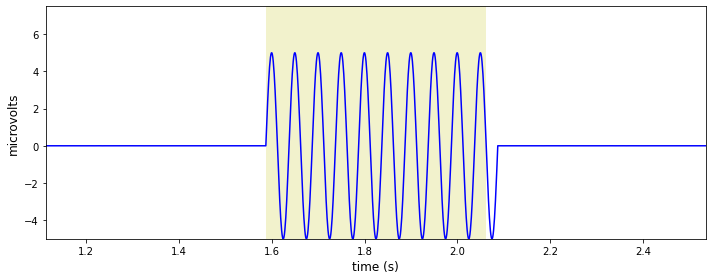

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
miny = np.min(laser_series) ; maxy = np.max(laser_series)* 1.5
ax.plot(time , laser_series, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)

first_laser_duration = time[laser_end[0]] - time[laser_start[0]]
ax.set_xlim(0, time[laser_end[0]] + first_laser_duration)
ax.set_ylim(miny, maxy)
ax.axvspan(time[laser_start[0]], time[laser_end[0]],  facecolor='y', alpha=0.2)
first_laser_duration = time[laser_end[0]] - time[laser_start[0]]
ax.set_xlim(time[laser_start[0]] - first_laser_duration, time[laser_end[0]] + first_laser_duration)
plt.tight_layout()

### (4.2) All stimulations

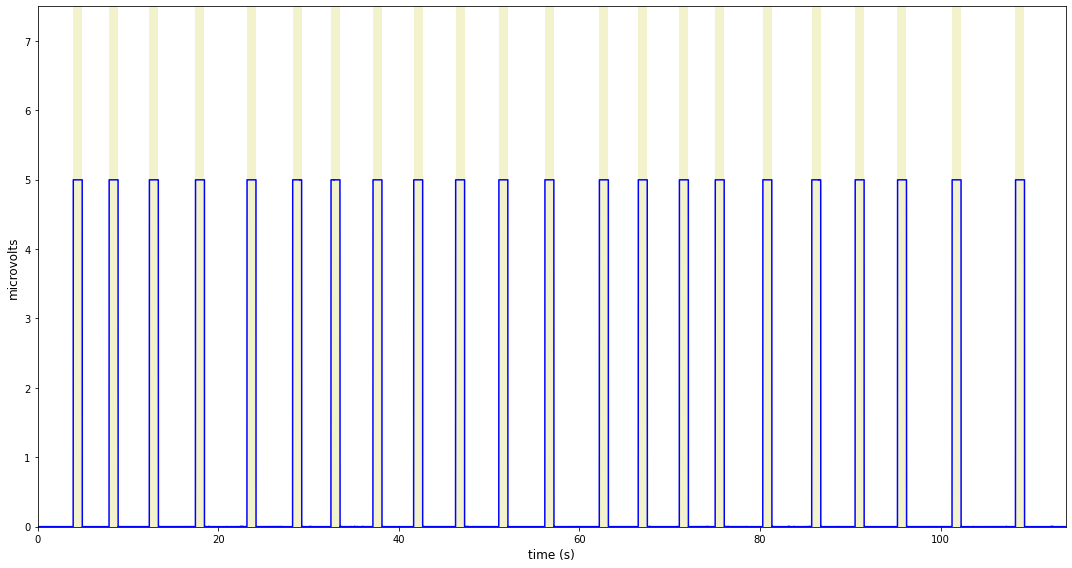

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
miny = np.min(laser_series) ; maxy = np.max(laser_series)* 1.5
ax.plot(time , laser_series, 'b') 
ax.set_xlabel('time (s)', fontsize=12)
ax.set_ylabel('microvolts', fontsize=12)
ax.set_xlim(0, secs)
ax.set_ylim(miny, maxy)
plt.tight_layout()

for (start, end) in zip(laser_start,laser_end):
    plt.axvspan(time[start], time[end],  facecolor='y', alpha=0.2)

## (5) Save laser stamps 

In [36]:
def save_laser_stamps_to_csv(filepath, laser_start, laser_end):
    
    metadatas=[[filepath],
                ["framerate : "],
                ["csv_aligned :", 'NO'],
               ["first_laser_time : ", 'None']
               ]
    df = pd.DataFrame(np.concatenate((laser_start.reshape(-1,1), laser_end.reshape(-1,1)),
                                      axis = 1) , 
                      columns = ['ON', 'OFF'])
    resultFilePath = filepath.replace(os.path.splitext(filename)[1], '.csv')
    with open(resultFilePath, 'w') as resultfile:

        csvResult=csv.writer(resultfile,delimiter=',', lineterminator='\n')
        csvResult.writerows(metadatas)

    df.to_csv(resultFilePath, mode = 'a', index = False)
save_laser_stamps_to_csv(filepath, laser_start, laser_end)